<a href="https://colab.research.google.com/github/seonaann/garbage_classification/blob/main/gar_class_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
!wget -O dataset-resized.zip https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip

--2025-06-28 14:07:56--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M   171MB/s    in 0.2s    

2025-06-28 14:07:57 (171 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



In [3]:
!unzip dataset-resized.zip -d dataset-resized

Archive:  dataset-resized.zip
   creating: dataset-resized/dataset-resized/
  inflating: dataset-resized/dataset-resized/.DS_Store  
   creating: dataset-resized/__MACOSX/
   creating: dataset-resized/__MACOSX/dataset-resized/
  inflating: dataset-resized/__MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/dataset-resized/cardboard/
  inflating: dataset-resized/dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/dataset-resized/cardboard/cardb

In [4]:
import os

print("Inside 'dataset-resized' folder:")
print(os.listdir("dataset-resized/dataset-resized"))

Inside 'dataset-resized' folder:
['trash', 'metal', 'plastic', 'paper', 'glass', 'cardboard', '.DS_Store']


In [5]:
dataset_path = "dataset-resized/dataset-resized"

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        print(f"{folder}: {count} images")

trash: 137 images
metal: 410 images
plastic: 482 images
paper: 594 images
glass: 501 images
cardboard: 403 images


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
dataset_dir = "dataset-resized/dataset-resized"
image_size = (260, 260)
#image_size = (128, 128)
batch_size = 32
seed = 42

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_class = val_ds.class_names
print("Class names:", val_class)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

# Prefetch to optimize pipeline
train_ds_eval = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds_eval = val_dat.cache().prefetch(tf.data.AUTOTUNE)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)


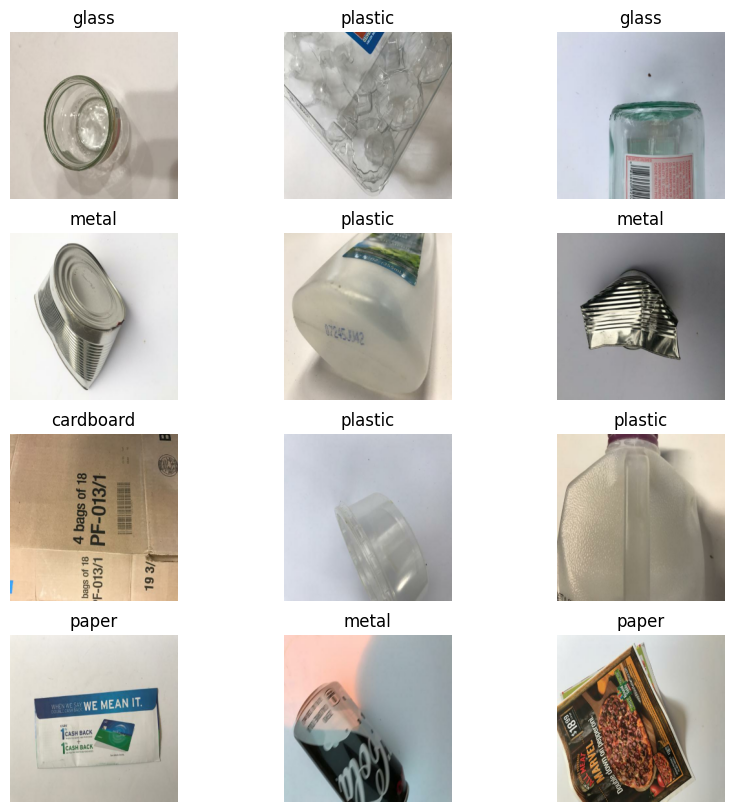

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")


In [11]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # percentage
    return counts


In [12]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


Train: {'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
Validation: {'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
Test: {'cardboard': 12.89, 'glass': 19.14, 'metal': 17.58, 'paper': 25.39, 'plastic': 17.58, 'trash': 7.42}
Overall: {'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


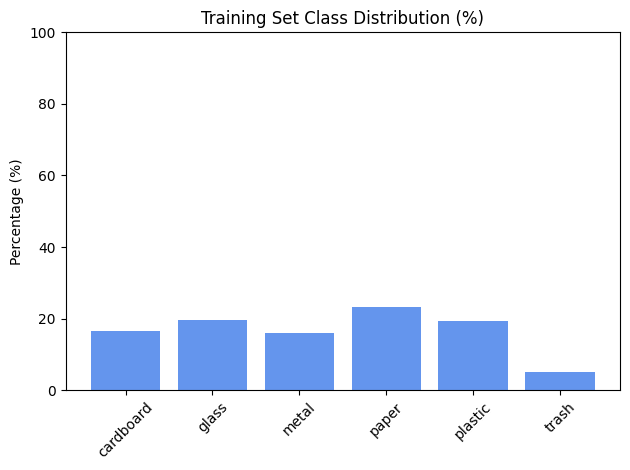

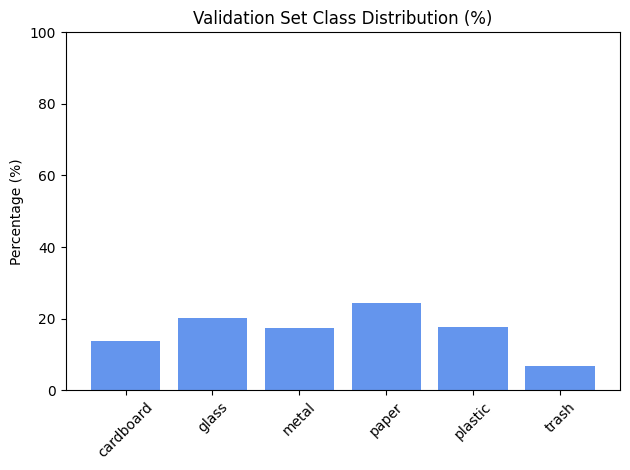

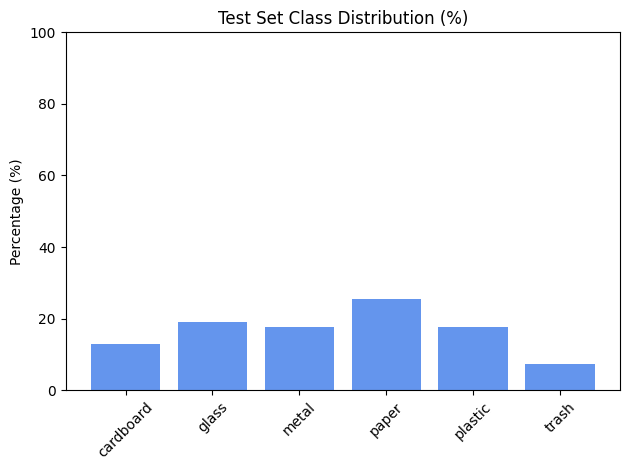

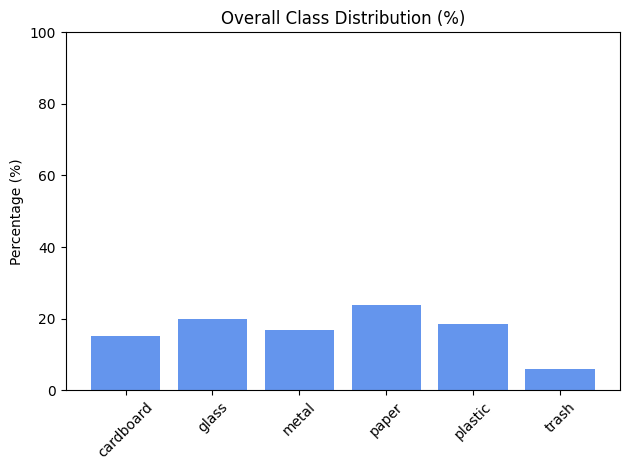

In [30]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)

overall_dist = {
    k: round((train_dist[k] + val_dist[k]) / 2, 2)
    for k in class_names
}

print("Train:", train_dist)
print("Validation:", val_dist)
print("Test:", test_dist)
print("Overall:", overall_dist)

simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


In [50]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for _, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [51]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Data augmentation pipeline

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])



In [52]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, Sequential, optimizers

# Load base model with preprocessing and ImageNet weights
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(260, 260, 3),
    include_preprocessing=True,
    weights='imagenet'
)

# Freeze first 100 layers to keep learned features
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


In [53]:
model = Sequential([
    layers.Input(shape=(260, 260, 3)),
    data_augmentation,                   # From your earlier step
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 classes: cardboard, glass, etc.
])


In [54]:
model.compile(
   optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [55]:
# Early stopping callback
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Set training parameters
epochs = 15

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, lr_scheduler]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 447ms/step - accuracy: 0.3668 - loss: 1.6116 - val_accuracy: 0.7188 - val_loss: 0.8969 - learning_rate: 1.0000e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.7775 - loss: 0.7656 - val_accuracy: 0.8713 - val_loss: 0.4838 - learning_rate: 1.0000e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.8634 - loss: 0.4611 - val_accuracy: 0.8950 - val_loss: 0.3436 - learning_rate: 1.0000e-04
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.9113 - loss: 0.2955 - val_accuracy: 0.9109 - val_loss: 0.2870 - learning_rate: 1.0000e-04
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.9270 - loss: 0.2301 - val_accuracy: 0.9267 - val_loss: 0.2560 - learning_rate: 1.0000e-04
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step - accuracy: 0.9650 - loss: 0.1364 - val_accuracy: 0.9267 - val_loss: 0.2332 - learning_rate: 1.0000e-04
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - acc

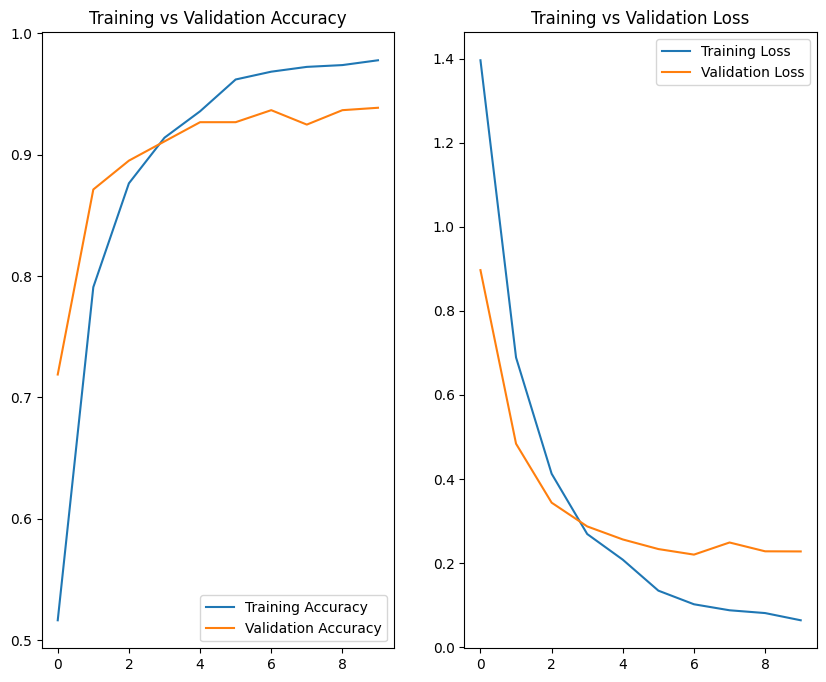

In [56]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend(loc='upper right')

plt.show()


In [57]:
# Evaluate model on the test dataset
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9290 - loss: 0.2989
Test accuracy is 0.9297, Test loss is 0.2643


In [58]:
# Extract true labels from the test dataset
y_true = np.concatenate([labels.numpy() for _, labels in test_ds_eval], axis=0)

# Get predicted probabilities
y_pred_probs = model.predict(test_ds_eval)

# Get predicted classes (argmax over probabilities)
y_pred = np.argmax(y_pred_probs, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


In [59]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Confusion Matrix:
[[30  0  1  1  0  0]
 [ 0 55  3  0  2  0]
 [ 0  1 38  0  0  1]
 [ 0  0  0 60  1  0]
 [ 0  2  2  0 41  2]
 [ 2  0  0  0  0 14]]

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.94      0.94      0.94        32
       glass       0.95      0.92      0.93        60
       metal       0.86      0.95      0.90        40
       paper       0.98      0.98      0.98        61
     plastic       0.93      0.87      0.90        47
       trash       0.82      0.88      0.85        16

    accuracy                           0.93       256
   macro avg       0.91      0.92      0.92       256
weighted avg       0.93      0.93      0.93       256



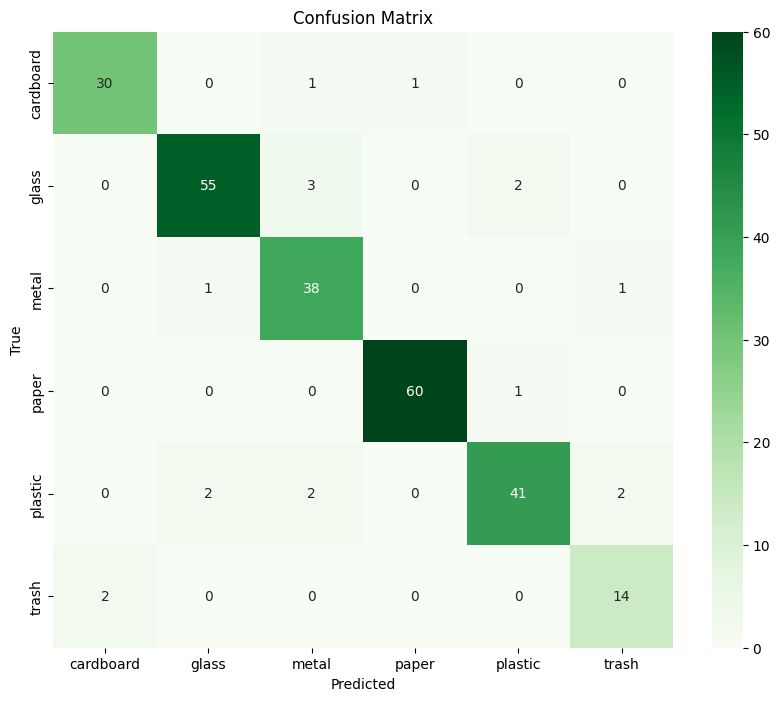

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


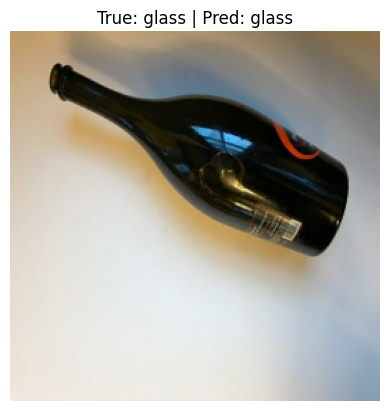

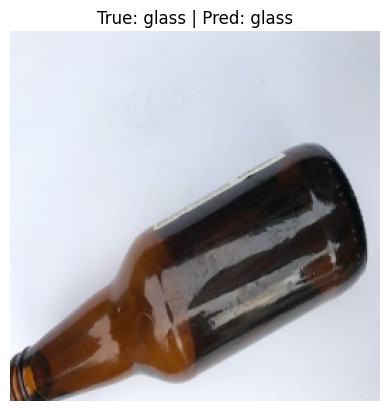

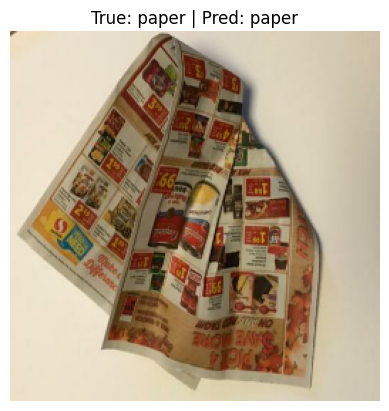

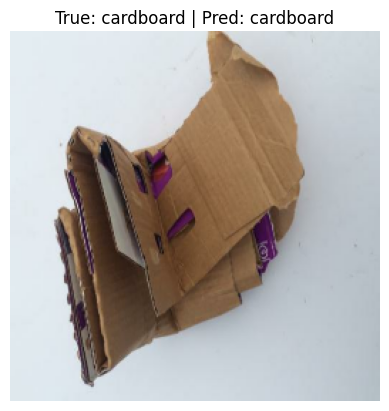

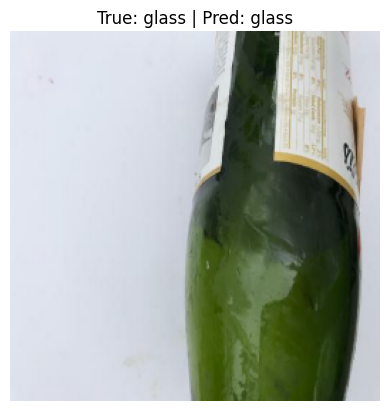

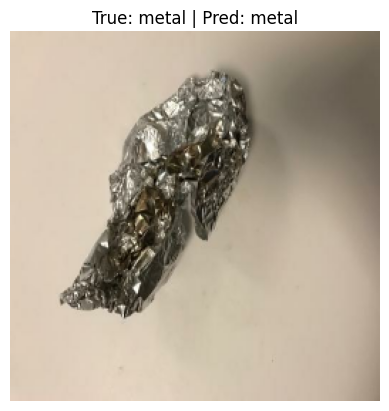

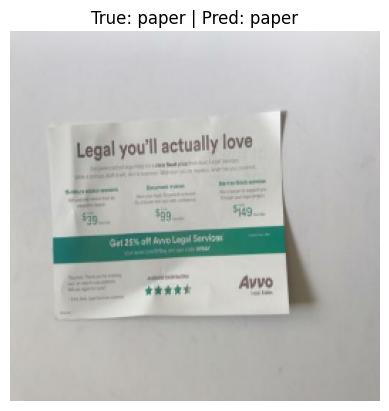

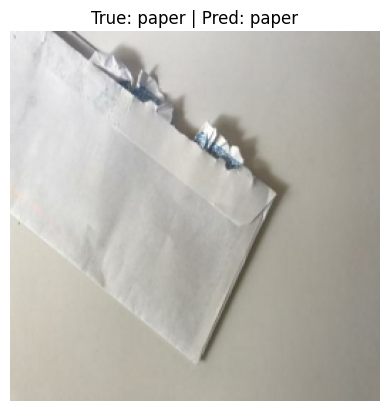

In [61]:
# Get class names from training dataset
class_names = train_ds.class_names

# Visualize predictions on a small batch of test images
for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)  # Get prediction probabilities
    pred_labels = tf.argmax(predictions, axis=1)  # Convert to predicted class indices

    # Show first 8 images with true and predicted labels
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [62]:
# Save model in the .keras format (recommended by TensorFlow)
model.save('efficientnetv2b2_model.keras')


In [63]:
# Load the saved model
loaded_model = tf.keras.models.load_model('efficientnetv2b2_model.keras')


In [64]:
!pip install gradio

In [66]:
import gradio as gr
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Load saved model
model = load_model("efficientnetv2b2_model.keras")

# Class names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Prediction function
def classify_image(img):
    img = img.resize((260, 260))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

# Gradio interface
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Classifier",
    description="Upload an image of garbage to classify it into cardboard, glass, metal, paper, plastic, or trash."
)

# Launch Gradio with public share link
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://807db19ac4d8319058.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [68]:
from google.colab import files
files.download("efficientnetv2b2_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>